In [1]:
%pip install -q -r ../../requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
import os
print(load_dotenv('../../.env'))
print(os.environ['LANGSMITH_PROJECT'])

True
agentic-ops


## Breakpoints for state update

In [3]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

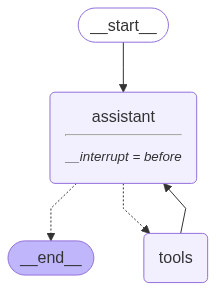

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [6]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='4c100e33-703e-43ff-8003-74800d281cfb')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f031cb9-585c-690e-8000-0a84854f031b'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-15T20:31:30.518034+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f031cb9-585a-6654-bfff-07ae6e10e6ed'}}, tasks=(PregelTask(id='5a126606-2eef-d631-1ce4-25c9ce7243bb', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

## Need to edit the state else gets append due to default add_message reducer

In [7]:
last_message_id = state.values['messages'][-1].id
last_message_id

'4c100e33-703e-43ff-8003-74800d281cfb'

In [8]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="actually multiply 3 and 3 !", id=last_message_id)]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f031cb9-5877-6858-8001-dc594cc209b2'}}

In [9]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

actually multiply 3 and 3 !


## No initial input needed to continue graph

In [10]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

actually multiply 3 and 3 !
================================== Ai Message ==================================
Tool Calls:
  multiply (call_A9S2jgjF2HRfQlDsiHSlxEpK)
 Call ID: call_A9S2jgjF2HRfQlDsiHSlxEpK
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9
